In [1]:
!pip install xgboost

from xgboost import XGBRegressor

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [48]:
import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import math

# Train, Validation, Test Data Split


In [49]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')
X_train_val = pd.read_csv('X_train_val.csv')
y_train_val = pd.read_csv('y_train_val.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')
X_train_scaled = pd.read_csv('X_train_scaled.csv')
y_train_scaled = pd.read_csv('y_train_scaled.csv')
X_val_scaled = pd.read_csv('X_val_scaled.csv')
X_train_val_scaled = pd.read_csv('X_train_val_scaled.csv')
y_train_val_scaled = pd.read_csv('y_train_val_scaled.csv')
X_test_scaled = pd.read_csv('X_test_scaled.csv')

In [50]:
train =  pd.read_csv('train.csv')
test =  pd.read_csv('test.csv')
train_val =  pd.read_csv('train_val.csv')
val =  pd.read_csv('val.csv')


In [51]:
feature_pool = X_train.columns

# Evaluation Metrics

In [59]:
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_rmse(y_true, y_pred): 
    
    return math.sqrt(mean_squared_error(y_true, y_pred))

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed, \
                          n_estimators, \
                          max_depth, \
                          learning_rate, \
                          min_child_weight, \
                          subsample, \
                          colsample_bytree, \
                          colsample_bylevel, \
                          gamma):

    model = XGBRegressor(objective ='reg:squarederror',seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    

    model.fit(X_train_scaled, y_train_scaled)
    
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [42]:
n_estimators = 100                         
max_depth = 3                               
learning_rate = 0.1                         
min_child_weight = 1                  
subsample = 1                  
colsample_bytree = 1           
colsample_bylevel = 1          
gamma = 0                      
model_seed = 100

In [71]:
#Using the default parameters, test on train scaled and evaluate on validation scaled 

rmse_bef_tuning, mape_bef_tuning, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_mean'],
                                     val['Close_std'],
                                     seed = model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)


print("RMSE on val set = ",  round(rmse_bef_tuning, 3) ) 
print("MAPE on val set = ",  round(mape_bef_tuning, 3) ) 

RMSE on val set =  3013.45
MAPE on val set =  19.171


/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


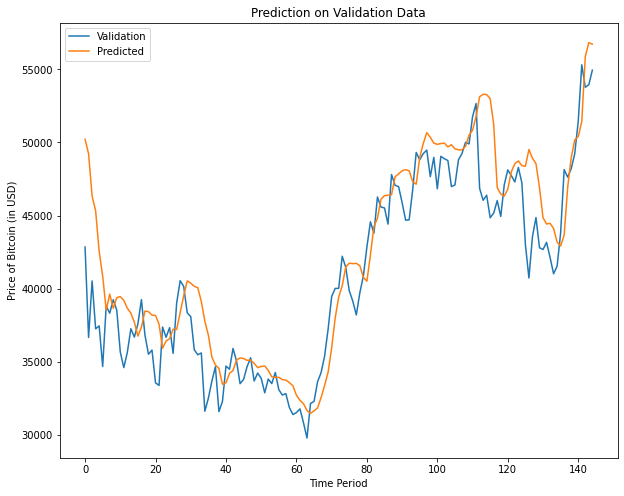

In [72]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

plt.plot(val['Close'], label = 'Validation') 
plt.plot(pred, label='Predicted')
plt.title("Prediction on Validation Data")
plt.xlabel("Time Period")
plt.ylabel("Price of Bitcoin (in USD)")
plt.legend()

In [73]:
imp = list(zip(train[feature_pool], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('Cryptocurrency_SVI_lag_5', 0.0013630483),
 ('Volume_lag_2', 0.0015947409),
 ('Cryptocurrency_SVI_lag_1', 0.0022629467),
 ('Close_lag_2', 0.006886076),
 ('Close_mean', 0.023037657),
 ('Close_lag_3', 0.033840515),
 ('Cryptocurrency_SVI_lag_3', 0.06363764),
 ('Close_lag_4', 0.24517114),
 ('Close_lag_5', 0.24884245),
 ('Close_lag_1', 0.35664618)]

# XGBoost : Hyperparameter Tuning

# No of Estimators, Max Depth 

In [74]:
param_label = 'n_estimators'
param_list = range(10, 500, 5)

param2_label = 'max_depth'
param2_list = [1, 2,3, 4, 5, 6, 7, 8, 9, 10]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}


for param in param_list:    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_mean'],
                                     val['Close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate   

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,n_estimators,max_depth,rmse,mape_pct
0,10,1,2907.023056,18.839749
1,10,2,2833.227425,18.717309
2,10,3,2811.661135,18.699543
3,10,4,2820.654098,18.696875
4,10,5,2812.277697,18.702436
...,...,...,...,...
975,495,6,3020.599345,19.188460
976,495,7,3005.693452,19.190362
977,495,8,2983.016801,19.156405
978,495,9,2993.900291,19.186428


In [75]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = ", round(error_rate['rmse'].min(), 3) ) 
print("optimum params = ", n_estimators_opt, max_depth_opt)

min RMSE =  2808.839
optimum params =  10 7


In [76]:
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ",  round(error_rate['mape_pct'].min(), 2))
print("optimum params = ", temp['n_estimators'].values[0], temp['max_depth'].values[0])

min MAPE =  18.7
optimum params =  10 4


# Learning Rate, Min Child Weights 

In [77]:
param_label = 'learning_rate'
param_list = list(np.arange(0.001, 1, 0.005)) 


param2_label = 'min_child_weight'
param2_list = range(1, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}

for param in (param_list):
    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                    y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_mean'],
                                     val['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)

error_rate   

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,1,2610.776308,17.975476
1,0.001,2,2610.776308,17.975476
2,0.001,3,2610.776820,17.975474
3,0.001,4,2610.789345,17.975405
4,0.001,5,2610.822239,17.975223
...,...,...,...,...
3995,0.996,16,2969.721640,19.161182
3996,0.996,17,3095.256728,19.319823
3997,0.996,18,2936.991463,19.083311
3998,0.996,19,3072.751067,19.313434


In [78]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = ", error_rate['rmse'].min())
print("optimum params = ",
learning_rate_opt, min_child_weight_opt)

min RMSE =  2610.280674803077
optimum params =  0.001 20


In [79]:
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ", round(error_rate['mape_pct'].min(), 3))
print("optimum params = ", 
temp['learning_rate'].values[0], temp['min_child_weight'].values[0])

min MAPE =  17.975
optimum params =  0.001 20


# Subsample, gamma

In [80]:
param_label = 'subsample'
param_list = list(np.arange(0.1, 1, 0.1))  

param2_label = 'gamma'
param2_list = list(np.arange(0.01, 1, 0.01))  

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}

for param in (param_list):
    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_mean'],
                                     val['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate   

/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,subsample,gamma,rmse,mape_pct
0,0.1,0.01,2609.688764,17.966354
1,0.1,0.02,2609.688764,17.966354
2,0.1,0.03,2609.688764,17.966354
3,0.1,0.04,2609.688764,17.966354
4,0.1,0.05,2609.688764,17.966354
...,...,...,...,...
886,0.9,0.95,2610.423304,17.974567
887,0.9,0.96,2610.423304,17.974567
888,0.9,0.97,2610.423304,17.974567
889,0.9,0.98,2610.423304,17.974567


In [81]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = ", round(error_rate['rmse'].min(), 3))
print("optimum params = ",
subsample_opt, gamma_opt)

min RMSE =  2609.689
optimum params =  0.1 0.01


In [82]:
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ", round(error_rate['mape_pct'].min(), 3))
print("optimum params = ",
temp['subsample'].values[0], temp['gamma'].values[0])

min MAPE =  17.966
optimum params =  0.1 0.01


# colsample_bytree, colsample_bylevel

In [83]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}

for param in (param_list):    
    for param2 in param2_list:
        rmse, mape, pred = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_val_scaled, 
                                     y_val, 
                                     val['Close_mean'],
                                     val['Close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate   



/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and wil

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,2609.682851,17.966343
1,0.5,0.6,2609.683786,17.966345
2,0.5,0.7,2609.684872,17.966347
3,0.5,0.8,2609.686381,17.966350
4,0.5,0.9,2609.686320,17.966349
5,0.5,1.0,2609.686320,17.966349
6,0.6,0.5,2609.783594,17.965896
7,0.6,0.6,2609.795200,17.965918
8,0.6,0.7,2609.685325,17.966348
9,0.6,0.8,2609.686320,17.966349


In [84]:
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = ", round(error_rate['rmse'].min(), 3))
print("optimum params = ",
colsample_bytree_opt, colsample_bylevel_opt)

min RMSE =  2609.683
optimum params =  0.5 0.5


In [85]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = ", round(error_rate['mape_pct'].min(), 3))
print("optimum params = ",
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0])

min MAPE =  17.966
optimum params =  0.6 0.5


# Tuned params

In [86]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params
tuned_params

,param,original,after_tuning
0,n_estimators,100.000000,10.000000
1,max_depth,3.000000,7.000000
2,learning_rate,0.100000,0.001000
3,min_child_weight,1.000000,20.000000
4,subsample,1.000000,0.100000
5,colsample_bytree,1.000000,0.500000
6,colsample_bylevel,1.000000,0.500000
7,gamma,0.000000,0.010000
8,rmse,3013.450322,2609.682851
9,mape_pct,19.170685,17.965896


In [87]:
rmse, mape, pred = train_pred_eval_model(X_train_val_scaled, 
                             y_train_val_scaled, 
                             X_test_scaled, 
                             y_test, 
                             test['Close_mean'],
                             test['Close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 2563.524
MAPE on test set = 21.804%


/Users/colin/miniconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


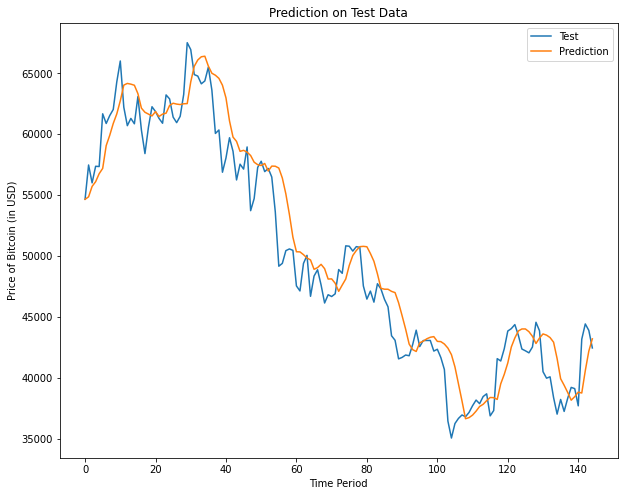

In [90]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

plt.plot(y_test['Close'], label = 'Test') 
plt.plot(pred, label='Prediction')
plt.title("Prediction on Test Data")
plt.xlabel("Time Period")
plt.ylabel("Price of Bitcoin (in USD)")
plt.legend()


# Prediction 

In [ ]:
test_scaled = test_scaled[feature_pool]
test_scaled

In [ ]:
row = test_scaled[-5:].mean()
row = pd.DataFrame(row)
row = row.T
row

In [ ]:
close_mean = test['Close_mean'][-5:].mean()
close_std = test['Close_std'][-5:].mean()

In [ ]:
model = XGBRegressor(seed=model_seed,
                     n_estimators=10,
                     max_depth=2,
                     learning_rate=0.016,
                     min_child_weight=1,
                     subsample=0.6,
                     colsample_bytree=0.5,
                     colsample_bylevel=0.6,
                     gamma=0.1)
model.fit(X_train_val_scaled,y_train_val_scaled)

In [ ]:
est_scaled = model.predict(row)
est = est_scaled * close_std + close_mean
est[0]

Reality: Bitcoin's market dominance fell 0.11 percent to 43.06 percent and the currency was trading at $41,430.77 on the morning of March 4.4 Mar 2022
